This notebook is my first attempt to explore the possibility of using satellite images and machine learning to detect and predict unidentified camping spots.

This will be a test dataset.  It can be downloaded from here: http://app.ioverlander.com/countries/places_by_country.  Specifically, I'll start with US data.  To avoid stressing their website, I just downloaded it for now.

In [52]:
import pandas as pd
import numpy as np
import bokeh
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# get data
USdata = pd.read_csv('iOverlander Places - United States - 2020-04-29.csv')

There is lots of interesting data here, but we are most interested in wild camping categories, since these are likely not established and would serve as the best source of test data.  Let's take a quick look at the data before subsetting it.

In [6]:
USdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14080 entries, 0 to 14079
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Location          2925 non-null   object 
 1   Name              14080 non-null  object 
 2   Category          14080 non-null  object 
 3   Description       14079 non-null  object 
 4   Latitude          14080 non-null  float64
 5   Longitude         14080 non-null  float64
 6   Altitude          13671 non-null  float64
 7   Date verified     14080 non-null  object 
 8   Open              14080 non-null  object 
 9   Electricity       11196 non-null  object 
 10  Wifi              11196 non-null  object 
 11  Kitchen           11196 non-null  object 
 12  Parking           86 non-null     object 
 13  Restaurant        11196 non-null  object 
 14  Showers           11196 non-null  object 
 15  Water             11196 non-null  object 
 16  Toilets           11196 non-null  object

In [15]:
USdata.head()

,Location,Name,Category,Description,Latitude,Longitude,Altitude,Date verified,Open,Electricity,Wifi,Kitchen,Parking,Restaurant,Showers,Water,Toilets,Big rig friendly,Tent friendly,Pet friendly
0,"Borrego Salton Seaway, Borrego Springs, CA 920...",Anza Borrego - NICE,Wild Camping,Free Camping on Anza Borrego Park. Nice and wa...,33.280572,-116.146887,0.00000,2019-01-28 00:00:00 UTC,Yes,Unknown,Unknown,Unknown,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,"Borrego Salton Seaway, Borrego Springs, CA 920...",Arroyo Salado Camping,Established Campground,"Free with two vault toilets, nothing else exis...",33.280188,-116.145788,0.00000,2020-02-16 14:20:45 UTC,Yes,No,No,No,NaN,No,No,No,Pit Toilets,Yes,Yes,Yes
2,"Unnamed Road, Austin, NV 89310, USA",Spencer Hotsprings,Wild Camping,Hammer site. Lots of places for vehicle or ten...,39.330567,-116.854627,1707.00000,2019-11-09 00:00:00 UTC,Yes,No,No,No,NaN,No,No,Natural Source,No,Yes,Yes,No
3,"Burr Trail Rd, Boulder, UT 84716, USA",Burr Trail - NICE,Wild Camping,Very quiet sleeping places on the Burr Trail t...,37.870193,-111.337513,1805.20752,2017-03-25 00:00:00 UTC,Yes,No,No,No,NaN,No,No,No,No,Unknown,Unknown,Unknown
4,"Coral Pink Sand Dunes Rd, Kanab, UT 84741, USA",Coral Pink Sand Dunes - OK,Wild Camping,Free camping without nothing in the BLM area. ...,37.068160,-112.702840,NaN,2012-01-01 00:00:00 UTC,Yes,Unknown,Unknown,Unknown,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [20]:
# display categories
USdata["Category"] = USdata["Category"].astype('category')
USdata["Category"].cat.categories

Index(['Checkpoint', 'Customs and Immigration', 'Established Campground',
       'Fuel Station', 'Hostel', 'Hotel', 'Informal Campsite', 'Laundromat',
       'Mechanic and Parts', 'Medical', 'Other', 'Pet Services', 'Propane',
       'Restaurant', 'Sanitation Dump Station', 'Shopping',
       'Tourist Attraction', 'Vehicle Insurance', 'Vehicle Shipping',
       'Vehicle Storage', 'Warning', 'Water', 'Wild Camping'],
      dtype='object')

In [35]:
# subset just some categories
USdata_filtered = USdata[USdata.Category.isin(['Wild Camping', 'Informal Campsite'])]
# print(USdata_filtered.shape)
# print(USdata_filtered.info())
# print(USdata_filtered[USdata.Category=='Informal Campsite'].shape)

# keep cols we need
USdata_filtered = USdata_filtered.iloc[:,0:6]
USdata_filtered.shape
USdata_filtered.head(10)


,Location,Name,Category,Description,Latitude,Longitude
0,"Borrego Salton Seaway, Borrego Springs, CA 920...",Anza Borrego - NICE,Wild Camping,Free Camping on Anza Borrego Park. Nice and wa...,33.280572,-116.146887
2,"Unnamed Road, Austin, NV 89310, USA",Spencer Hotsprings,Wild Camping,Hammer site. Lots of places for vehicle or ten...,39.330567,-116.854627
3,"Burr Trail Rd, Boulder, UT 84716, USA",Burr Trail - NICE,Wild Camping,Very quiet sleeping places on the Burr Trail t...,37.870193,-111.337513
4,"Coral Pink Sand Dunes Rd, Kanab, UT 84741, USA",Coral Pink Sand Dunes - OK,Wild Camping,Free camping without nothing in the BLM area. ...,37.068160,-112.702840
5,"Lincoln Highway, Ruth, NV 89319, USA",Ely - OK,Wild Camping,"Cookies at the 50 to Ely. Heard BLM. Fire pit,...",39.310427,-114.990007
6,"National Forest Development Road 427, Ely, NV ...",Elyn - OK,Wild Camping,"Sleeping area in NF. Was super quiet here, alb...",39.509519,-114.680790
7,"Anniversary Mine Road, Overton, NV 89040, USA",Lake Mead RA - NICE,Wild Camping,Nice place outside the Lake Mead Recreation Ar...,36.201047,-114.685437
8,"159 East 300 South, Kanab, UT 84741, USA",McDonalds Kanab - NAJA,Informal Campsite,Shakedown at McDonalds in Kanab for the mornin...,37.043630,-112.525112
9,"Mc Nerney Rd, Brawley, CA 92227, USA",Salton Sea - OK,Wild Camping,Sleeping place behind a palm tree at the Salto...,33.074692,-115.656803
10,"497-499 Gazos Creek Road, Pescadero, CA 94060,...",San Mateo - OK,Wild Camping,Quiet place to sleep far away from the main ro...,37.185469,-122.333737


Now let's try to map these points to google maps, then we can get the satellite images to train our ML algorithm.

In [40]:
import ee
import datetime
ee.Authenticate()

Enter verification code: 4/zAHmH8F9dWZCcLg1-pWlOtPgDhzJWwnbRZe6FESAY6fJwKt7LVggkwA

Successfully saved authorization token.


In [55]:
#ee.Initialize()

well, until my access gets approved, this isn't going to work.

In [50]:
# test that things work
# Print the elevation of Mount Everest.
# dem = ee.Image('USGS/SRTMGL1_003')
# xy = ee.Geometry.Point([86.9250, 27.9881])
# elev = dem.sample(xy, 30).first().get('elevation').getInfo()
# print('Mount Everest elevation (m):', elev)

In [ ]:
# # get images for analysis

# // Load a landsat image and select three bands.
# var landsat = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_123032_20140515')
#   .select(['B4', 'B3', 'B2']);

# // Create a geometry representing an export region.
# var geometry = ee.Geometry.Rectangle([116.2621, 39.8412, 116.4849, 40.01236]);

# // Export the image, specifying scale and region.
# Export.image.toDrive({
#   image: landsat,
#   description: 'imageToDriveExample',
#   scale: 30,
#   region: geometry
# });

let's try another approach using geopandas

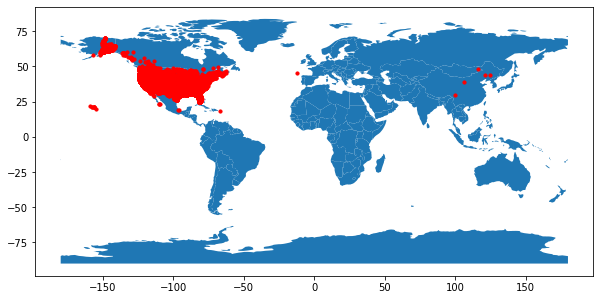

In [59]:
geometry = [Point(xy) for xy in zip(USdata_filtered['Longitude'], USdata_filtered['Latitude'])]
gdf = GeoDataFrame(USdata_filtered, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=10);

Looks like there is some incorrect coordinates, we'll clean that up later.

Let's get the slope of these points because slope is important for nice campsites.  Also, let's just focus on one state for now, Colorado.

In [79]:
import requests

In [108]:
# subset just colorado
USdata_filtered2 = USdata_filtered[USdata_filtered.Name.str.contains('CO', case=False, regex=False)]
print(USdata_filtered2.shape)

(491, 7)


In [157]:
# set site to get elevation
URL = "https://nationalmap.gov/epqs/pqs.php?"

# test with 10 for now
USdata_filtered2_10 = USdata_filtered2.head(10)
USdata_filtered2_10['Elevation'] = ''
elevation_lst = []

for index, row in USdata_filtered2_10.iterrows():
    long = row['Longitude']
    lat = row['Latitude']
    PARAMS = 'x=' + str(long) + '&y=' + str(lat) + '&units=Feet&output=json'
    # sending get request and saving the response as r object 
    r = requests.get(url = URL, params = PARAMS) 
    data = r.json()
    elevation_lst += [data['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']]

#USdata_filtered2_10['Elevation'] = elevation_lst

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [158]:
USdata_filtered2_10.head(10)

,Location,Name,Category,Description,Latitude,Longitude,geometry,Elevation
4,"Coral Pink Sand Dunes Rd, Kanab, UT 84741, USA",Coral Pink Sand Dunes - OK,Wild Camping,Free camping without nothing in the BLM area. ...,37.068160,-112.702840,POINT (-112.70284 37.06816),
51,"Redwood Hwy, Trinidad, CA 95570, USA",Trinidad County Rest Area,Informal Campsite,"Apparently in California, you can stay at a St...",41.092150,-124.150180,POINT (-124.15018 41.09215),
81,"United States, I-10 E",New Mexico Welcome Center,Informal Campsite,Free to camp out in their parking lot overnigh...,32.352800,-108.742847,POINT (-108.74285 32.35280),
100,"United States, Arizona, Yavapai, Soda Springs Rd",Coconino Forest Arizona,Informal Campsite,"Free Trailer Parkingmeter,nice",34.676579,-111.719450,POINT (-111.71945 34.67658),
113,"1-35 Peacock Ln, Cloudcroft, NM 88317, USA",Lincoln National Forest Wild Camp,Wild Camping,Lots of pull outs off this forest road to camp...,32.903124,-105.771536,POINT (-105.77154 32.90312),
130,"Inyo National Forest, Buttermilk Road, Bishop,...",Bishop I Buttrmilk Country,Wild Camping,Free camping in the Inyo National forest.,37.328330,-118.579230,POINT (-118.57923 37.32833),
167,"NF-522, Flagstaff, AZ 86001, USA","Coconino NF, Dispersed Camping",Wild Camping,14 or so(sites 10-14 closed when we were here)...,35.292600,-111.704196,POINT (-111.70420 35.29260),
168,"Cottonwood Canyon Rd, Utah, USA","Cottonwood Canyon, BLM",Wild Camping,Nice little spot about 25 miles outside of Bry...,37.322792,-111.882778,POINT (-111.88278 37.32279),
198,"North Slope Haul Road, Alaska, USA",33km After Coldfoot,Wild Camping,"Nice place way off the Dalton Hgw. Seemingly, ...",67.486139,-149.880977,POINT (-149.88098 67.48614),
292,"I-70, Thompson, UT 84540, USA",WelcomeToUtahCamp,Informal Campsite,"Beautiful landscape, I did park at the informa...",38.951888,-109.684204,POINT (-109.68420 38.95189),
